In [15]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS

In [2]:
suppl = Chem.SDMolSupplier('../Phase-CQS/Common_Comp_set_topo.sdf')

In [3]:
def readMOl(A):
    data = []
    Mols = []
    for mol in suppl:
        if mol is not None:
            R = Chem.MolToSmiles(mol)
            if R not in data:
                data.append(R)
                Mols.append(mol)

    return(Mols)

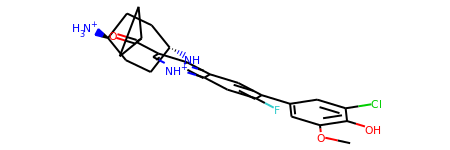

In [4]:
moles = readMOl(suppl)
moles[0]

In [5]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m in moles]

# How many compounds/fingerprints do we have?
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 318
Fingerprint length per compound: 2048


In [6]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [7]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [8]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.2)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  66
# clusters with only 1 compound:  33
# clusters with >5 compounds:  10
# clusters with >25 compounds:  3
# clusters with >100 compounds:  0


Number of clusters 66 from 318 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 65
Similarity between two random points in same cluster 0.86
Similarity between two random points in different cluster 0.22


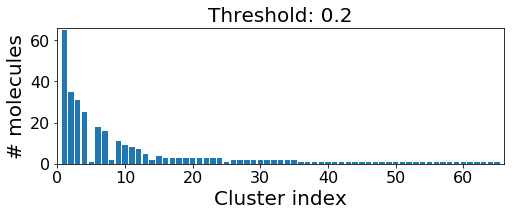

In [9]:
dist_co = 0.2
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(moles), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

In [10]:
#Write cluster members in file
def clusterMember(Number):
    filename = '../Phase-CQS/cluster/cluster-'+str(Number)+'.sdf'
    w = Chem.SDWriter(filename)
    dd = list(clusters[Number])
    print(dd)
    for x in dd:
        Name = moles[x].GetProp('_Name')
        print(Name)
        w.write(moles[x])

In [11]:
for s in range(0,65):
    clusterMember(s)

[248, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263]

































































[119, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 131, 132, 133, 134, 141, 183, 189]



































[14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 196, 197, 198]
CHEMBL3740844
CHEMBL3739689
CHEMBL3740472
CHEMBL3740669
CHEMBL3741918
CHEMBL3741377
CHEMBL3739611
CHEMBL3741608
CHEMBL3742145
CHEMBL3741062
CHEMBL3741595
CHEMBL3740732
CHEMBL3741224
CHEMBL3739931
CHEMBL3740612
CHEMBL3739647
CHEMBL3741787
CHEMBL3741821
CHEMBL3739862
CHEMBL3741733

In [12]:
def clusterMCS(Number):
    ml = []
    for x in clusters[Number]:
        ml.append(moles[x])
    
    
    return(ml)

SMARTS string: [#6]1(:[#7]:[#6]:[#7](:[#6]:1)-[#6])-[#6](-[#7]-[#6]1-[#6](-[#7](-[#6]-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2)-[#6])-[#6](-[#8])-[#6](-[#6]-1)-[#8]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)=[#8]
SMARTS string: CN(CC1:C:C:C:C:C:1)C1C(NC(=O)C2:C:N(C):C:N:2)CC(OC2:C:C:C:C:C:2)C1O


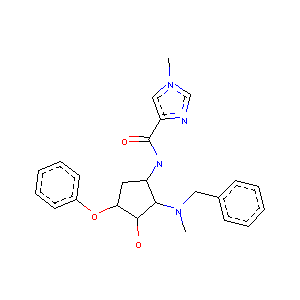

In [47]:
jj = clusterMCS(30)
mcs1 = rdFMCS.FindMCS(jj)
print('SMARTS string: %s'%mcs1.smartsString)
# Draw substructure
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolToSmiles(m1)
print('SMARTS string: %s'%m2)
Draw.MolToImage(m1,subImgSize=(400,400))

#img.save('../../Phase/cluster/Cluster-MCS-5.png')

Ten molecules from largest cluster:


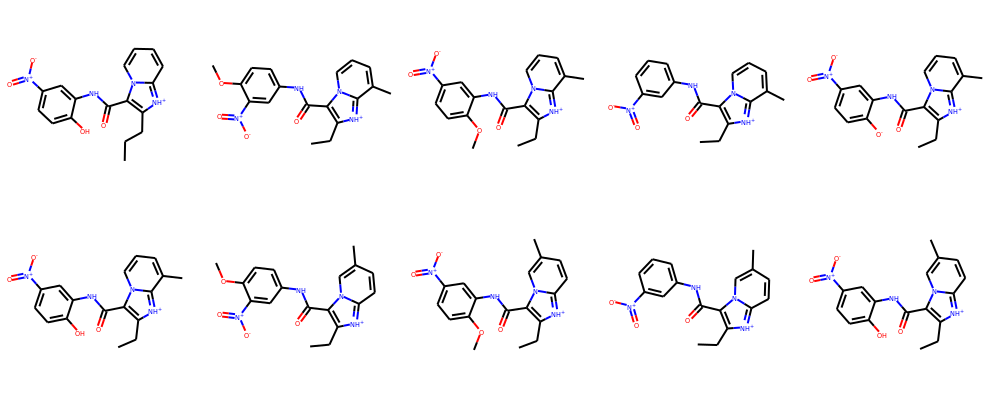

In [25]:
print ('Ten molecules from largest cluster:')
# Draw molecules

Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(moles[i])) for i in clusters[0][:10]], legends=[moles[i].GetProp('_Name') for i in clusters[0][:10]], molsPerRow=5)

In [33]:
print ('Ten molecules from first 10 clusters:')
# Draw molecules
img = Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(moles[clusters[i][0]])) for i in range(60,66)], 
                     legends=[moles[clusters[i][0]].GetProp('_Name') for i in range(60,66)], 
                     molsPerRow=5,subImgSize=(250,250))

img.save('../Phase-CQS/cluster/cluster-60-66-Rep.png')

Ten molecules from first 10 clusters:


In [87]:
def MOlToSmile(A):
    data = []
    scaffold = []
    for mol in A:
        if mol is not None:
            name = mol.GetProp('_Name')
            core=MurckoScaffold.MakeScaffoldGeneric(mol)
            S = Chem.MolToSmiles(core)
            if S not in data:
                data.append(S)
                scaffold.append(core)

    return(S)